# Project 1 - Data Engineering
## 2 Data Exploration and Analysis
This notebook is for the implementation of task "2 Data Exploration and Analysis", as listed in the **Project Instructions**.

<div class="alert alert-success">
<b>Overview:</b><br>
Data Exploration and Analysis consists of the following parts worth 70 points:
<ul>
    <li><b>E1 - Obtain and Scrub</b> (15 points)</li>
    <li><b>E2 - Exploratory data analysis (EDA) </b>(20 points)</li>
    <li><b>E3 - Formulate hypotheses </b>(25 points)</li>
    <li><b>Follow the guidelines for Data Exploration and Analysis below </b>(10 points)</li>
</ul></div>

<div class="alert alert-success">
<b>Guidelines for Data Exploration and Analysis:</b><br>
    <ol>
        <li>Use a single Jupyer notebook for your project.</li>
        <li>Use only Python-code for your project.</li>
        <li>The use of automatic and semi-automatic data analyis tools is not allowed (e. g., PandasGUI, D-Tale, Mito, etc.). Only use packages we used in the coded lectures.</li>
        <li>Export your environment for submission as 'prj01-environment.txt'.</li>
        <li>Upload your resulting work as a zip file containing only a single jupyter notebook and required files to run the notebook. All cell outputs and <b>figures must display in jupyter lab</b>. (Test this, in particular when you use another environment like VS Code.)</li>
        <li>All code cells in your notebook must be runnable without errors or warnings (e. g., deprecated functions). Each error/warning subtracts -2 points (up to the full 10 points for following the  guidelines).</li>
        <li>Use only relative paths in your project.</li>
        <li>Avoid (excessive) code duplication.</li>
        <li>Avoid loops iterating over pandas objects (Series, DataFrames). Explicitly justify each exception via a comment. </li>
        <li>All coded steps in your analysis must be commented.</li>
        <li>Keep your code as well as outputs short, precise and readable. Each long or unnecessary output subtracts -2 points (up to the full 10 points for following the project guidelines).</li>
    </ol>
    <b>Late submissions are not accepted and earn you 0 points on the python project. </b>
</div>

Explicitly list which notebook toolset was used (jupyter lab/jupyter notebook/VS Code/etc.)

**here**: MY_TOOL, MY_BROWSER

Explicitly and clearly state the chosen dataset number and title:
### Bevölkerung ODÖ Hunde
#### Hundebestand seit 2002 - Bezirke Wien --> contains info about dog density per districts over years
#### Hunde pro Bezirk Wien --> contains info about dog breeds count per district in 2024
#### Hunderassen Wien --> contains info about dog breeds count per district 2012 - 2017


## E1 - Obtain and Scrub

### Obtain
Download the dataset and understand both:
- format: wide vs. long, separaters, decimal points, encoding, etc., and
- content: what variables are in the columns, what is their meaning?
To this end, identify and download metadata such as headers, category listings, explanatory reports, etc.
### Scrub
The aim of scrub is to create a clean version of the data for further analysis.
- Load the dataset and take care of dtypes (dates, numbers, categories, etc.). Justify why you don't load/use specific columns.
- Check for footnotes or any other notifications on special cell content, such as time series breaks. Follow up that information, and document your decision how to deal with it. Remember: A homework contained such info in the cell "76.1 b". The metadata defines what that "b" stands for.
- Choose an appropriate (Multi-)Index.
- Identify:
    1. missing values and get row and column overviews. Use graphical and/or numeric approaches. Once identified, handle missing values according to column type, time series property and data set size.
    2. duplicates (justify the used column subset). Remove duplicates - if any - and inspect what you removed.
- Transform to shape (tidy vs. wide) best suited for further analysis.
- Export the clean data to a file for inspection with an external data browser (e.g., MS Excel).
- Provide an overview of the clean dataset:
    1. show the dtypes
    2. quantitative column descriptions:
        1. categorical columns: number of unique values, counts
        2. numeric columns: range and median

In [ ]:
# Importing necessary packages:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps
import geopandas as gpd
import json # to read in geojson
from matplotlib.lines import Line2D # for custom legend
import re
%matplotlib inline

## 1) Obtain the datasets and scrub data


#### 1) Dataset 1
Number of dogs (absolute and per 1,000 inhabitants) since 2002 - districts of Vienna
 	* NUTS | NUTS2-Region (Bundesland)
  * DISTRICT_CODE | Gemeindebezirkskennzahl (Schema: 9BBZZ, BB=Nummer Bezirk, ZZ=00)
  * SUB_DISTRICT_CODE | Zählbezirkskennzahl gemäß Stadt Wien (Schema: 9BBZZ, 9=Kennzeichnung Wien, BB=Nummer Bezirk, ZZ=Nummer Zählbezirk, **ZZ=99 bei fehlender Zählbezirkskennzeichnung**)
  * REF_YEAR | Referenzjahr
  * REF_DATE | Referenzdatum
  * DOG_VALUE | Anzahl der Hunde (absolut)
  * DOG_DENSITY | Anzahl der Hunde pro 1.000 EinwohnerInnen

Source: https://www.data.gv.at/katalog/dataset/1a48e78a-c660-41e0-ac32-8b675c0ea39c#additional-info

   TODO: add more description?

##### Obtain

In [ ]:
# Import the first data set
dogs_2002 = pd.read_csv("vie-bez-biz-spo-dog-2002f.csv", sep=';', skiprows=1, dtype={"DOG_VALUE": "object", "DOG_DENSITY": "object"})
print("Dataframe shape: ", dogs_2002.shape)
dogs_2002.head(5)

* The separator is ';'.
* The encoding is 'utf-8'.
* The original shape is (528, 17) - but many columns full of NaNs (later: cleaned up data => shape=(528, 7)).
* Long format:  
  * Contains entries for years by district of overall dog density sorted by years.
  * each row represents a single observation of district by year and dog breeds
* The first row contains the csv title. It is dropped and the second row is used for column titles.
* First column 'NUTS' (= identification and classification system for european states) contains always the same value, since 'AT13' stands for Vienna (and we only have data for Vienna in this dataset). We could drop it, but it also doesn't bother us too much right now
* DISTRICT_CODE '90000' stands for all districts combined
* Need to import DOG_VALUE as objects because the '.' in some values does not allow conversion to integer right now. Without specifying it, the values are recognised as floats.
* We also import DOG_DENSITY as objects because we need to convert the ',' to '.' to allow conversion to floats afterwards


##### Scrub

In [ ]:
# check columns and their missing data ratio
((dogs_2002.isnull().sum() / len(dogs_2002)) * 100).sort_values(ascending=False)

In [ ]:
# drop all cols with NaN --> lots because of multiple 'unnecessary' seperators ';' in last columns
# other columns have no missing values
dogs_2002 = dogs_2002.dropna(axis=1, how='any')
print("Dataframe shape: ", dogs_2002.shape)

In [ ]:
print(dogs_2002.dtypes)

Remove '.' in DOG_VALUE and convert to integer.

Change DOG_DENSITY to use '.' instead of ',' and the format to float to be able to calculate with it, if needed.

Change REF_DATE to format datetime since its currently int64.

In [ ]:
dogs_2002['DOG_VALUE'] = dogs_2002['DOG_VALUE'].str.replace('.', '', regex=False).astype(int)
dogs_2002['DOG_DENSITY'] = dogs_2002['DOG_DENSITY'].str.replace(',', '.', regex=False).astype(float)
dogs_2002['REF_DATE'] = pd.to_datetime(dogs_2002['REF_DATE'].astype(str), format='%Y%m%d')

In [ ]:
print(dogs_2002.dtypes)
dogs_2002.head(2)

* District Code and Sub District Code are the same --> removing Sub District Code
* add Postal_CODE column for better comparison between datasets

In [ ]:
# only execute if not already done (avoids errors)
if 'SUB_DISTRICT_CODE' in dogs_2002.columns:
    print(np.unique([dogs_2002['DISTRICT_CODE'] == dogs_2002['SUB_DISTRICT_CODE']], return_counts=True)) # check that columns are actually the same
    dogs_2002.drop(columns=['SUB_DISTRICT_CODE'], inplace=True)
dogs_2002["Postal_CODE"] = "1" + dogs_2002['DISTRICT_CODE'].astype(str).str[1:3] + "0"
dogs_2002.head(2) # Postal_CODE=1000 represents Vienna in total

Check for duplicates --> looks good:

In [ ]:
dogs_2002.duplicated(subset=['DISTRICT_CODE', 'REF_YEAR']).any()

#### Dataset 2
  Number of registered dogs in Vienna per district and dog breed in the year 2024.

  * NUTS1 NUTS2 NUTS3: same as before, but NUTS3 in addition: provides district information for Vienna
  * DISTRICT_CODE: same structure as before
  * SUB_DISTRICT_CODE
  * Postal_CODE
  * Dog Breed
  * Anzahl
  * Ref_Date

Source: https://www.data.gv.at/katalog/dataset/71edef44-9d6c-4042-ab71-7207dc930ba7#additional-info

##### Obtain

In [ ]:
# Import dataset 2
dog_types_2024 = pd.read_csv("hunde-wien.csv", sep=';', encoding='latin-1', skiprows=1, dtype={"Anzahl": "object"})

print("Dataframe shape: ", dog_types_2024.shape)
dog_types_2024.head(5)

* The separator is ';'
* The encoding is 'latin-1'.
* The shape is (11117, 9).
* Mixed breeds are also included, like 'Hovawart / Golden Retriever'.
* Format is long:
  * dog breeds can appear multiple times in breed-column. This is the case if at least two dogs of a breed are registered in different districts. If there is no dog of a specific breed registered in a distric, it is not listed in the dataset for this district.
  * Every district and breed combination has a single count value
* We import 'Anzahl'-column as objects, because there is a value that contains a '.' (Point). Therefore, it would be recognised as a float even though these values should be all integers.

##### Scrub

In [ ]:
# check columns and their missing data ratio => no missing data
((dog_types_2024.isnull().sum() / len(dog_types_2024)) * 100).sort_values(ascending=False)

In [ ]:
dog_types_2024.dtypes.to_frame().T

Looks like some columns only have 1 unique value => NUTS1-3, SUB_DISTRICT_CODE and Ref_Date to be exact. Also, no district is missing, which is good.

In [ ]:
dog_types_2024.nunique()

In [ ]:
print("DISTRICT_CODE:", dog_types_2024["DISTRICT_CODE"].unique())
print("Postal_CODE:", dog_types_2024["Postal_CODE"].unique())

Drop NUTS1, NUTS2, NUTS3 and SUB_DISTRICT CODE. Don't want to drop Ref_Date yet, maybe could be used for some insights with the above data frame.

In [ ]:
dog_types_2024 = dog_types_2024.drop(['NUTS1', 'NUTS2', 'NUTS3', 'SUB_DISTRICT_CODE'], axis=1)
dog_types_2024['Ref_Date'] = pd.to_datetime(dog_types_2024['Ref_Date'].astype(str), format='%Y%m%d')
dog_types_2024.dtypes.to_frame().T

The 'Anzahl'-column contains one value that currently cannot be converted to an integer without losing information. It seems that there are 1012 dogs of mixed breed 'Unbekannt / Mischling', which would be recognised as a float with decimal places:

In [ ]:
dog_types_2024[dog_types_2024["Anzahl"].str.contains(".", regex=False)]

In [ ]:
dog_types_2024["Anzahl"] = dog_types_2024["Anzahl"].str.replace('.','', regex=False).astype(int)
print(dog_types_2024.dtypes) # we could also change dtype for 'Dog Breed' to 'category', but 3500 categories are a bit much. We leave it for now
dog_types_2024.head(2)

Check if some Dog Breeds have duplicates per district --> looks good.

In [ ]:
dog_types_2024.duplicated(subset=['Dog Breed', 'Postal_CODE']).any()

Check if there are unknown Dog Breeds:
  * There appear to be in total 50 entries in the dataset with at least partly unknown Dog Breeds.
  * There are in total 8200 dogs with an at least partly uknown dog breed.
  * The dataset has only 6 unique values in the 'Dog Breed'-column that contain an unknown dog breed.
  * They are kept for the moment.

In [ ]:
def check_for_unknown_dog_breeds(df: pd.DataFrame):
    bool_unknown = df['Dog Breed'].str.contains('Unbekannt', case=False)
    print("Total number of entries with unknown dog breed:", bool_unknown.sum())
    print("Total number of dogs with at least partly unknown dog breed:", df[bool_unknown]["Anzahl"].sum())
    tmp_array = df[bool_unknown]['Dog Breed'].unique()
    print("Number of unknown dog breeds:", len(tmp_array))
    print("Unknown dog breeds:", tmp_array)

check_for_unknown_dog_breeds(dog_types_2024)

In [ ]:
dog_types_2024.head()

We could also drop the postal_code column, since it basically provides the same data as the district_code column:

In [ ]:
(dog_types_2024["DISTRICT_CODE"].astype(str).str[1:3] == dog_types_2024["Postal_CODE"].astype(str).str[1:3]).unique() # compare 2-digit district code

#### Dataset 3
Number of registered dogs in Vienna per district and dog breed in the years 2012 to 2017. 

The layout of the dataset is basically the same as the one before, we only have data for multiple years.

  * NUTS1: AT1
  * NUTS2: AT13
  * NUTS3: AT113
  * DISTRICT_CODE: Bezirke, Format 9BB00
  * SUB_DISTRICT_CODE: Zählbezirk, leer
  * Postal_CODE: Postleitzahl, Format 1BB0
  * Dog Breed: Hunderasse
  * Anzahl: Anzahl der jeweiligen Hunderasse
  * Ref_Date: Jahr

Source: https://www.data.gv.at/katalog/dataset/31f526f5-2cf2-49f8-a63d-0c63a0f87a3e

In [ ]:
# Import dataset 3
dog_types_2012 = pd.read_csv("hunde-vie.csv", sep=';', encoding='latin-1', skiprows=1, dtype={"Anzahl": "object"})

print("Dataframe shape: ", dog_types_2012.shape)
dog_types_2012.head(5)

* The separator is ';'
* The encoding is 'latin-1'.
* The shape is (33793, 9).
* Format is long:
  * dog breeds can appear multiple times in breed-column. This is the case if at least two dogs of a breed are registered in different districts or in different years. If there is no dog of a specific breed registered in a distric, it is not listed in the dataset for this district.
  * Every district, ref_date and breed combination has a single count value
* We import the 'Anzahl'-column as objects and process them the same way as in the previous dataset.


Repeat steps as with dataframe 2, since they have the same format.

In [ ]:
# check columns and their missing data ratio => no missing data
((dog_types_2012.isnull().sum() / len(dog_types_2012)) * 100).sort_values(ascending=False)

Looks like some columns only have 1 unique value => NUTS1-3 and SUB_DISTRICT_CODE to be exact. Also, no district is missing, which is good. We have 6 different years in the dataset:

In [ ]:
dog_types_2012.nunique()

Column Ref_Date contains more entries than above, lets see which years are included: 2012 to 2017

In [ ]:
dog_types_2012['Ref_Date'].value_counts()

In [ ]:
print(dog_types_2012.groupby("Ref_Date")["DISTRICT_CODE"].nunique()) # no districts missing in each year
print(dog_types_2012.groupby("Ref_Date")["Postal_CODE"].nunique())

In [ ]:
dog_types_2012.dtypes.to_frame().T

'Anzahl' can be converted to integer this time without any additional steps:

In [ ]:
print(dog_types_2012[dog_types_2012["Anzahl"].str.contains(r"[\.\,]", regex=True)]) # no entry with '.' or ','
dog_types_2012["Anzahl"] = dog_types_2012["Anzahl"].astype(int)

Change Ref_Date from int64 to date (important: format is now different to before: yyyy**dd**mm, not yyyymm**dd**):

In [ ]:
dog_types_2012 = dog_types_2012.drop(['NUTS1', 'NUTS2', 'NUTS3', 'SUB_DISTRICT_CODE'], axis=1)
dog_types_2012['Ref_Date'] = pd.to_datetime(dog_types_2012['Ref_Date'].astype(str), format='%Y%d%m') # convert int to real datetime
print(dog_types_2012.dtypes.to_frame().T)

Check for duplicates and unkown dog breeds --> has only the unknown dog breed 'Unbekannt' and no duplicates too.
* Unkown can stay for now, even though their number is very high with 98.707 dogs (even if we consider that the dataset contains multiple years of data).



In [ ]:
dog_types_2012.duplicated(subset=['Dog Breed', 'Postal_CODE', 'Ref_Date']).any()

In [ ]:
check_for_unknown_dog_breeds(dog_types_2012)

### Merging Dataset 2 and 3 as they contain the same info for different years

In [ ]:
print(dog_types_2024.dtypes.to_frame().T)
print(dog_types_2012.dtypes.to_frame().T)

In [ ]:
combined_dog_types = pd.concat([dog_types_2012, dog_types_2024]) # dataframes have same columns => concat
print("Shape:", combined_dog_types.shape)

In [ ]:
combined_dog_types_by_year_and_district = combined_dog_types.pivot_table(index=['Ref_Date', 'Postal_CODE'], columns='Dog Breed', values='Anzahl', fill_value=0).sort_values(by='Ref_Date', ascending=False)
combined_dog_types_by_year_and_district.head(2)

Sanity Check: 

Values are the same (apart from 0) --> looks good. 

In [ ]:
unique_values = []
unique_values_single = []
for col in combined_dog_types_by_year_and_district.columns:
    unique_values.extend(combined_dog_types_by_year_and_district[col].unique())

unique_values_single.extend(dog_types_2012['Anzahl'].unique())
unique_values_single.extend(dog_types_2024['Anzahl'].unique())
unique_values_single = set(unique_values_single)
unique_values = set(unique_values)
differences = unique_values.symmetric_difference(unique_values_single)
print(differences)

## E2 - Exploratory data analysis (EDA)
Use the clean dataset and understand and explore the relationships in the data (numerical, visual, statistical). This includes at least but is not limited to:
- A comprehensive textual description of meaning for relevant fields in the dataset
- Statistical/numerical descriptions and visualization techniques we learned in the course inluding correlations, distributions and groupings of variing degrees.
- Checks for data quality, e. g., completeness, plausibility, outliers
- Handling any identified problems with the data
- If necessary, use additional data wrangling in line with your EDA and only keep what's necessary for the following steps of your analysis with appropriate data granularity and form ("tidy data")

Don't:
- test/prove hypotheses here. EDA should only motivate hypotheses.

Advanced/bonus:
- Depending on your hypothesis you may want to join external data (e.g., merge external highest education level to existing vaccination data) for additional insights.

Explain all steps taken and your thinking why you deem them necessary.

In [ ]:
# No missing data - TODO: heatmaps still necessary?


BOXPLOTS

In [ ]:
# dogs_2002: Check which DOG_VALUEs are outliers for each year
# TODO: add comments
df_dogs_2002_boxplots = dogs_2002[(dogs_2002["Postal_CODE"] != "1000")].sort_values(by=["REF_YEAR", "Postal_CODE"], ascending=[True, True]) # sort for year first, so we can correctly append the isOutlier column
array_is_outlier = np.array([], dtype=bool)
whis_ratio = 1.5
for year in range(df_dogs_2002_boxplots["REF_YEAR"].min(), df_dogs_2002_boxplots["REF_YEAR"].max() + 1): # using loop across years to calculate quartiles only once per year
    tmp_filtered_df = df_dogs_2002_boxplots[df_dogs_2002_boxplots["REF_YEAR"] == year] # save filtered df because we need it multiple times
    first_quartile, median, third_quartile = tmp_filtered_df["DOG_VALUE"].quantile([0.25, 0.5, 0.75])
    len_whisk = (third_quartile - first_quartile) * whis_ratio
    upper_whisk_limit = third_quartile + len_whisk
    lower_whisk_limit = first_quartile - len_whisk
    array_is_outlier = np.append(array_is_outlier, 
                                 np.where( (tmp_filtered_df["DOG_VALUE"] > upper_whisk_limit) | (tmp_filtered_df["DOG_VALUE"] < lower_whisk_limit), # if outlier, set True
                                          True, False))
df_dogs_2002_boxplots["Outlier"] = array_is_outlier

palette = sns.color_palette("Set2")[0:2] # get two colors from a sns palette
g = sns.boxplot(df_dogs_2002_boxplots, y="DOG_VALUE", x='REF_YEAR', width=.5, whis = whis_ratio, legend=False)
g = sns.swarmplot(df_dogs_2002_boxplots, y="DOG_VALUE", x='REF_YEAR', size=3.25, hue='Outlier', palette=palette, legend=False)
outlier_districts = df_dogs_2002_boxplots[df_dogs_2002_boxplots["Outlier"]]["Postal_CODE"].unique()
plt.legend(title=None, labels=[f"Outlier districts: {', '.join(outlier_districts)}"], handles=[Line2D([0],[0], marker='o', color='w', label='Scatter', markerfacecolor=palette[1], markersize=7)])
sns.despine()    # remove the top and right line in graph
g.figure.set_size_inches(15,6)
g.set(xlabel="Year", ylabel="Absolute number of dogs")
g.set_title("Absolute number of dogs in Vienna per year", loc="left", weight='bold', fontsize=18)
x_location = g.axes.get_xticklabels()[-1].get_position()[0]
for district in outlier_districts:
    y_location = df_dogs_2002_boxplots[(df_dogs_2002_boxplots["REF_YEAR"]==2023) & (df_dogs_2002_boxplots["Postal_CODE"]==district)]["DOG_VALUE"].values[0] + 150
    plt.annotate(text=district, xy=(x_location, y_location))
plt.show()
# TODO: please remove output of this cell (=plot) before commit

BARPLOTS

In [ ]:
# Not so good - Barplot: Dogs per breed in Vienna per year
#df_top10_2012 = dog_types_2012.groupby(["Ref_Date", "Dog Breed"]).agg(count = ("Anzahl", "sum")).sort_values(["count"], ascending=False).groupby(["Ref_Date"]).head(100) # double groupby and agg using sum-function to avoid deprecation warning of other methods
#df_top10_2012 = df_top10_2012.reset_index()
#fig = px.bar(df_top10_2012, x="Ref_Date", y="count", color="Dog Breed", title="Dogs per breed in Vienna per year")
# TODO: leftshift years 1 year
#fig.show()

In [ ]:
# Plot: Absolute number of dogs of the top 30 breeds (across all districts in 2024)
sum_dog_types_2024 = pd.DataFrame(dog_types_2024.groupby("Dog Breed")["Anzahl"].sum())
top30_sum_dog_types_2024 = sum_dog_types_2024.sort_values(by="Anzahl", ascending=False).head(30).reset_index()
bool_unbekannt_top30_2024 = top30_sum_dog_types_2024["Dog Breed"].str.contains("Unbekannt", case=False)

fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(top30_sum_dog_types_2024, x="Anzahl", y="Dog Breed", color="blue", ax=ax)
sns.despine(ax=ax, trim=True)
for i in np.arange(len(top30_sum_dog_types_2024))[bool_unbekannt_top30_2024]:
    ax.patches[i].set_color('orange')
ax.set_title("Absolute number of dogs of the top 30 breeds (across all districts in 2024)\n[Unknown marked in orange]", loc="left")
ax.grid(axis="x")
# TODO: please remove output of this cell (=plot) before commit

**Barplot motivates Hypothesis 3**: Small dogs like Chihuahuas, Malteser, French Bulldog are very popular. Are smaller dogs generally preferred as pets?

In [ ]:
# Barplot: Absolute number of dogs across all districts in Vienna per year (dogs_2002)
fig = px.bar(dogs_2002[dogs_2002["Postal_CODE"] != "1000"], x="REF_YEAR", y="DOG_VALUE", color="Postal_CODE", title="Absolute number of dogs across all districts in Vienna per year (2002-2023)",
             labels={"REF_YEAR": "year","DOG_VALUE": "Absolute number of dogs","Postal_CODE": "postal code"}
            )
fig.update_xaxes(dtick=1)
fig.show()
# TODO: please remove output of this cell (=plot) before commit

In [ ]:
# TODO: delete or find useful plot
df_top10_2024 = dog_types_2024.groupby(["Postal_CODE", "Dog Breed"]).agg(count = ("Anzahl", "sum")).sort_values(["count"], ascending=False).groupby(["Postal_CODE"]).head(10) # double groupby and agg using sum-function to avoid deprecation warning of other methods
df_top10_2024 = df_top10_2024.reset_index()

In [ ]:
# plot: total number of dogs per district and year
# TODO: how to handle jump between 2018 and 2024? Make colors better, maybe continuous color scale?
df_years_district = pd.DataFrame(combined_dog_types.groupby(["Ref_Date", "Postal_CODE"])["Anzahl"].sum().reset_index())
px.line(df_years_district, x="Ref_Date", y="Anzahl", color='Postal_CODE', markers=True)
# TODO: please remove output of this cell (=plot) before commit

In [ ]:
# preprocessing for geo-data plots
df_beznr_district_mapping = pd.read_csv("beznr-district-mapping.csv", sep=',', dtype={"BEZNR": object}) # additional mapping between beznr and district name because geojson contains only name of district
df_beznr_district_mapping.head(2)

In [ ]:
# plot: total number of dogs per district and year
df_years_district["BEZNR"] = df_years_district["Postal_CODE"].astype(str).str[1:3].astype("int32").astype(str)
df_years_district["year"] = df_years_district["Ref_Date"].dt.strftime("%Y").astype("int32")
df_years_district = df_years_district.merge(df_beznr_district_mapping, on="BEZNR", how="left")
with open('vienna_.geojson', 'r', encoding="utf8") as file:
    geo_json = json.load(file)
fig = px.choropleth(df_years_district,
                    geojson=geo_json,
                    color="Anzahl",
                    animation_frame='year',
                    locations="District_Name",
                    featureidkey="properties.name",
                    projection="mercator",
                    color_continuous_scale="deep",
                    title="Total number of dogs per district and year"
                   ) # TODO: maybe use log scaling
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(height=500,width=500)
fig.show()
# TODO: please remove output of this cell (=plot) before commit

In [ ]:
# plot: absolute number of dogs since 2002
geo_dogs_2002 = dogs_2002.copy()
geo_dogs_2002["BEZNR"] = geo_dogs_2002["DISTRICT_CODE"].astype(str).str[1:3].astype("int32").astype(str)
geo_dogs_2002 = geo_dogs_2002.merge(df_beznr_district_mapping, on="BEZNR", how="left")
fig = px.choropleth(geo_dogs_2002,
                    geojson=geo_json,
                    color=np.log2(geo_dogs_2002["DOG_VALUE"]), # TODO: maybe use log scaling
                    animation_frame='REF_YEAR',
                    locations="District_Name",
                    featureidkey="properties.name",
                    projection="mercator",
                    color_continuous_scale="deep",
                    title="absolute number of dogs since 2002"
                   ) 
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(height=500,width=500)
fig.update_layout(coloraxis_colorbar=dict(
    title="Absolute number [log2]"#,
    #tickvals=[6,7,8,9],
    #ticktext=["", "10M", "100M", "1B"],
))
fig.show()
# TODO: maybe concentrate on some specific districts
# TODO: please remove output of this cell (=plot) before commit

Distribution of dog breeds over districts --> how many different dog breeds are there per district?

In [ ]:
df_count_breeds_per_district = (combined_dog_types_by_year_and_district > 0).astype(int).sum(axis=1)
df_count_breeds_per_district = df_count_breeds_per_district.reset_index().sort_values(by=['Ref_Date'])
df_count_breeds_per_district.columns = ['Ref_Date', 'Postal_CODE', 'Count']
df_count_breeds_per_district

In [ ]:
df_count_breeds_per_district['Ref_Date'] = df_count_breeds_per_district['Ref_Date'].dt.date

# Plot the data in a facet grid
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')

# used catplot for categorical data 
g = sns.catplot(
    x='Postal_CODE', 
    y='Count', 
    col='Ref_Date', 
    col_wrap=3, 
    data=df_count_breeds_per_district, 
    kind='bar'
)
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

plt.show();

Observation: The diversity of dogs in Vienna increased noticeably between 2017 and 2024.

## E3 - Formulate hypotheses

*Note: Read this section entirely and understand it - every group member.*

A hypothesis is an idea or explanation for something that is based on known facts but has not yet been proved. A hypothesis is a compact, concise statement, such as: "Individuals with higher income have (on average) more offspring.", that will be answered based on facts (the data). https://gradcoach.com/what-is-a-research-hypothesis-or-scientific-hypothesis/

Formulate *N* non-trivial hypotheses, 1 per group member, and regard the following criteria:
- State the hypothesis explicitly in concise language.
- The hypothesis must be **motivated** by either **EDA results** or **literature** (citation in the report needed).
- The hypothesis must refer to **endpoints** that are **testable**. Specifically, the endpoint must be derived from the data.
- Think of real-life use cases/consequences of your results (textual description).
- For each hypothesis explain all executed steps.
- In case of extreme or implausible results check the validity of your data.
- For each hypothesis export the artifacts (figures, tables, etc.) required for the report.
- If you decide to use a statistical test, use it properly. In particular, check the validity and comparability of the samples.

Do not:
- State nebulous, vague hypotheses. These don't contain endpoints and are unclear to test (i.e., answer).
- Use post-hoc hypotheses. Portraying an empirically inspired **post hoc hypothesis as a priori** violates the **falsification principle** crucial for hypothesis-driven (that is, confirmatory) empirical research. Falsification is severe scientific fraud.
- State trivial hypotheses (e.g., hypthesis 2: "Not Hypothesis 1").
- Answer based on "common knowledge".
- Try to **produce positively tested hypotheses**. If a well motivated hypothesis is negative, this is an important finding (see Simpson's Paradox). The value of a tested hypothesis lies in the information or learning it provides.

Example: The homework with Simpson's Paradox. The pooled overall comparison between the genders would be the EDA motivating the hypothesis: "At UC Berkeley the by-department admissions rate for females is lower than for males." It should be tested using samples of department admission rates for the 2 **groups** male and female. No steps of the test should be done in EDA (or a priory to stating the hypothesis). The groups should be compared graphically, e.g., via a stripplot overlayed with a boxplot. The figure should be labelled properly and exported for the report. A (paired) t-test **may** be used (it's optional) to test this hypothesis statistically. For different data (e.g., time series) different approaches may be required. You don't have to use statistical tests, in particular if you don't know what they are doing.


---

### E3-H1: "The prevalence of specific dog breeds in Vienna is strongly influenced by real estate prices."

Rationale: Higher real estate prices may attract certain dog breeds, indicating a potential link between the types of dogs found in high-income areas and local housing costs.

Data Needed: 
- Dog breed data (`hunde-vie.csv` / `hunde-wien.csv`).
- Real estate prices dataset.

Author: Carlos Eduardo Tichy

---

### Supporting Evidence and Insights

While there is no direct study linking **dog breed prevalence** to **real estate prices** specifically in Vienna, several sources suggest that **housing conditions and socio-economic factors** do influence dog breed choices across Europe.

1. **Housing Conditions**: A study noted that housing conditions, such as **living in an apartment or house with a garden**, strongly influence the types of dogs people own. In urban areas with high real estate prices, smaller breeds, like **French Bulldogs or Chihuahuas**, are more common due to space constraints. In contrast, **larger breeds**, such as Golden Retrievers or German Shepherds, tend to be more prevalent in suburban or rural areas where properties are larger and more affordable  .

2. **Socio-Demographic Factors**: Research also highlights that wealthier households or those in areas with **higher disposable income** are more likely to own certain breeds that are more expensive to maintain, such as **purebred dogs**. Similarly, a rise in **single-person households** and more flexible work patterns (like remote work) have made dog ownership more common in urban areas, further influencing breed choices based on lifestyle  .

3. **Popularity and Behavior**: Another study found that certain breeds become popular in specific socio-economic environments due to **behavioral traits** that suit urban living. For example, dogs that are **trainable, less aggressive, or more adaptable to confined spaces** are preferred in cities .

These insights suggest a clear relationship between the environment (including **real estate prices**) and **dog breed selection**, even if specific studies on Vienna are yet to emerge.

---

**Sources**:

1. [The Influence of Breed, Sex, Origin and Housing Conditions on Undesirable Behaviors in Ancient Dog Breeds](https://www.mdpi.com/2076-2615/11/5/1435)
2. [The Rise of Dog Ownership in Europe: A Decade in Review](https://rochsociety.com/research-european-dog-ownership-2010-2022/)
3. [Socio-demographic factors associated with pet ownership amongst adolescents from a UK birth cohort](https://bmcvetres.biomedcentral.com/articles/10.1186/s12917-019-2063-x)
4. [Fashion vs. Function in Cultural Evolution: The Case of Dog Breed Popularity](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0074770)

---

### E3-H2: "There is a positive correlation between the ownership of Listenhunde and district, with a higher prevalence of Listenhunde ownership in outer viennese districts compared to inner districts."

Listenhunde are specific dog breeds which must be registered and owning them comes with specific regulations, such as always walk your dog with a muzzle and a leash, except when in fully gated dog areas. Owners must complete a 'Hundeführerschein' as well, for which you have to be at least 16 years old. Thereby, if you are under the age of 16, you are not allowed to walk this dog breed. Note that all dogs, which contain one of the breeds from the list are considered a Listenhund.  

Rationale: It could be easier to own a Listenhund in an outer district, as there aren't as many people around (acceptance) as well as more free spaces. Additionally, other provinces have different regulations, which might be more favorable and would make traveling distances shorter. 

Data Needed: Dog breed data ('hunde-vie.csv'/hunde-wien.csv)

Author: Theresa Spiel

---

**Sources**: 
1. [Haltung von Listenhunden in Wien](https://www.oesterreich.gv.at/themen/reisen_und_freizeit/haustiere/1/2/Seite.742280.html)
2. [All regulations for Listenhunde in Austria](https://www.oesterreich.gv.at/themen/reisen_und_freizeit/haustiere/1/2.html)
---


Start with getting all dog breeds per district.

In [ ]:
dog_breeds_per_district = combined_dog_types_by_year_and_district.reset_index().melt(id_vars=[ 'Ref_Date', 'Postal_CODE'], value_vars=combined_dog_types_by_year_and_district.columns, value_name='Count')
dog_breeds_per_district["year"] = dog_breeds_per_district["Ref_Date"].dt.strftime("%Y").astype("int32")
dog_breeds_per_district

There are many mixed breeds --> aggregate mixed breeds and introduce Primary and Secondary Breed. 

In [ ]:
#[print(x) for x in dog_breeds_per_district["Dog Breed"].unique()];
dog_breeds_per_district['Dog Breed'] = dog_breeds_per_district['Dog Breed'].str.replace('-', '')

dog_breeds_per_district[['Primary Breed', 'Secondary Breed']] = dog_breeds_per_district['Dog Breed'].str.split(' / ', n=1, expand=True).astype(str)
dog_breeds_per_district['Secondary Breed'] = dog_breeds_per_district['Secondary Breed'].replace('None', np.nan)

# Check for potentially redundant breed names
potentially_redundant = {}
for breed in dog_breeds_per_district["Primary Breed"].unique():
    stripped = re.sub(r'[^a-zA-Z]', '', breed).lower()
    if stripped in potentially_redundant:
        potentially_redundant[stripped].append(breed)
    else:
        potentially_redundant[stripped] = [breed]

# fix redundant breeds (same breed, but written different, only upper lower differences, missing space and such) 
for stripped, breeds in potentially_redundant.items():
    if len(breeds) > 1:
        dog_breeds_per_district.loc[dog_breeds_per_district['Primary Breed'] == breeds[1], 'Primary Breed'] = str(breeds[0])

# add (rein) to every entry where secondary is NaN to not mix pure breeds and mixed breeds
dog_breeds_per_district.loc[dog_breeds_per_district['Secondary Breed'].isna(), 'Primary Breed'] += ' (pure)'
dog_breeds_per_district.loc[~dog_breeds_per_district['Secondary Breed'].isna(), 'Primary Breed'] += ' (mixed)'

# drop entries with Unbekannt (rein) 
dog_breeds_per_district = dog_breeds_per_district[dog_breeds_per_district['Primary Breed'] != 'Unbekannt (pure)']
dog_breeds_per_district = dog_breeds_per_district[dog_breeds_per_district['Primary Breed'] != 'Unbekannt (mixed)']

dog_breeds_per_district.sort_values(by=['Ref_Date'], ascending=True)
dog_breeds_per_district.head()

There is still 1044 unique values, but we need to take mixed vs pure into account. 

In [ ]:
len(dog_breeds_per_district['Primary Breed'].unique())

Plot all primary breeds as histogram per breed, separated by year (with an animation frame) and the histogram being split into the districts. Upon zooming in, we can see there is a prevalesence for specific dog breeds, but this plot is too crowded yet, to gain insights for Listenhunde. 

In [ ]:
# Using a interactive histogram to display the distribution of dog breeds per district 
def show_interactive_histogram(dataframe, x, y, color, title, yaxes_text):
    fig = px.histogram(data_frame=dataframe, x=x, y=y, color=color, height=1000,
                     title=title, animation_frame="year")
    fig.update_yaxes(title_text=yaxes_text)
    fig.update_xaxes(tickangle=45)
    fig.update_layout(
        updatemenus=[dict(y=-0.22, x=-0.16, xanchor="left", yanchor="top")],
        sliders=[dict(y=-0.2, x=0.1, xanchor="left", yanchor="top")],
        margin=dict(b=150)
    )
    fig.show()

In [ ]:
show_interactive_histogram(
    dataframe=dog_breeds_per_district, 
    x = 'Primary Breed', 
    y = 'Count', 
    color = 'Postal_CODE', 
    title='Dog Breeds per Year/District', 
    yaxes_text='Count',
)

In [ ]:
list_dogs = ['Bullterrier', 'Staffordshire Bullterrier', 'American Staffordshire Terrier', 'Mastino Napoletano', 'Mastin Espanol', 'Fila Brasileiro', 'Mastiff', 'Bullmastiff', 'Tosa Inu', 
    'Pit Bull Terrier', 'Rottweiler', 'Dogo Argentino', 'Argentinischer Mastiff']
[x.strip(" ") for x in list_dogs];

Filter for Listenhunde and display those. Shows general distribution of Listenhunde. 

In [ ]:
mask = dog_breeds_per_district['Primary Breed'].str.strip(" ").str.contains('|'.join(list_dogs), case=False, na=False)
matching_breeds = dog_breeds_per_district[mask].sort_values(by=['Ref_Date'], ascending=True)
matching_breeds['Primary Breed'] = matching_breeds['Primary Breed'].str.replace(" (pure)", "", regex=False).str.replace(" (mixed)", "", regex=False)

In [ ]:
show_interactive_histogram(
    dataframe=matching_breeds, 
    x = 'Primary Breed', 
    y = 'Count', 
    color = 'Postal_CODE', 
    title='Listenhunde per Year/District', 
    yaxes_text='Count',
)

Show Listenhunde by year and district. 

In [ ]:
def show_interactive_histogram_per_district(dataframe, x, y, color, title, yaxes_text):
    fig = px.histogram(data_frame=dataframe, 
                       x=x, 
                       y=y, 
                       color=color, 
                       height=1000,
                       title=title,
                       animation_frame="year",  
                       nbins=len(matching_breeds['Postal_CODE'].unique())
                      )
    fig.update_yaxes(title_text=yaxes_text)
    fig.update_xaxes(tickangle=45, tickvals=dataframe[x].unique() )
    fig.update_layout(bargap=0.2)
    fig.show()

In [ ]:
show_interactive_histogram_per_district(
    dataframe=matching_breeds, 
    x = 'Postal_CODE', 
    y = 'Count', 
    color = 'Primary Breed', 
    title='Listenhunde per Year/District', 
    yaxes_text='Count',
)

Recall Vienna's district borders. Outer districts are those districts which border to neighbouring provinces.
- outer_districts = [1100, 1110, 1130, 1140, 1170,  1190, 1210, 1220, 1230]
- inner_districts = [1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1120, 1150, 1160, 1180, 1200]



In [ ]:
gdf = gpd.read_file("BEZIRKSGRENZEOGD.json")
gdf = gdf.set_index('BEZNR').sort_index()

ax = gdf.plot(color='none', edgecolor='red')
# gcf -> get current figure , set title
plt.gcf().suptitle('Vienna\'s district borders')
ax.set_xlabel('Lon °')
ax.set_ylabel('Lat °')

# Plot the index for each district
for idx, row in gdf.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, str(idx), ha='center')

plt.show()

Split into outer and inner districts and look for distribution difference 

In [ ]:
matching_breeds.head()

In [ ]:
outer_districts = [1100, 1110, 1130, 1140, 1170,  1190, 1210, 1220, 1230]
inner_districts = [1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1120, 1150, 1160, 1180, 1200]

matching_breeds_inner = matching_breeds[matching_breeds['Postal_CODE'].isin(inner_districts)]
matching_breeds_outer = matching_breeds[matching_breeds['Postal_CODE'].isin(outer_districts)]

print("Sanity Check - number of postal codes in both dfs: ") 
matching_breeds_inner['Postal_CODE'].nunique() + matching_breeds_outer['Postal_CODE'].nunique()

Comparing the absolute sum of Listenhunde in inner and outer districts supports the hypothesis. 

In [ ]:
print("Listenhunde innere Bezirke: ", matching_breeds_inner['Count'].sum())
print("Einträge: ", len(matching_breeds_inner))

In [ ]:
print("Listenhund äußere Bezirke: ", matching_breeds_outer['Count'].sum())
print("Einträge: ", len(matching_breeds_outer))

Lets look at the subgroups in more detail: 

In [ ]:
show_interactive_histogram_per_district(
    dataframe=matching_breeds_inner, 
    x = 'Postal_CODE', 
    y = 'Count', 
    color = 'Primary Breed', 
    title='Listenhunde per Year / Inner Districts', 
    yaxes_text='Count',
)

In [ ]:
show_interactive_histogram_per_district(
    dataframe=matching_breeds_outer, 
    x = 'Postal_CODE', 
    y = 'Count', 
    color = 'Primary Breed', 
    title='Listenhunde per Year/ Outer Districts', 
    yaxes_text='Count',
)

Lets see if there is a correlation between breed and district. 

In [ ]:
from scipy import stats

# calculate correlation between Listenhund breed and postal code
def calculate_correlation(breed):
    breed_data = matching_breeds[matching_breeds['Primary Breed'] == breed]
    return stats.pearsonr(breed_data['Count'], breed_data['Postal_CODE'])[0]

top_breeds = matching_breeds.groupby('Primary Breed')['Count'].sum().index
correlations = {breed: calculate_correlation(breed) for breed in top_breeds}

plt.figure(figsize=(12, 6))
breeds = list(correlations.keys())
values = list(correlations.values())
plt.scatter(breeds, values, label='Correlation Coefficients')

plt.title('Correlation between Listenhund Breed Popularity and District')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Breed')
plt.legend()
plt.tight_layout()
plt.show()

There is a weak correaltion between list dog breed owned and district, with only three breeds > 0.2. The lower the result, the less relationship there is, therefore, a value of ~0.3 and less is not statistically significant. 
[Pearson Correlation Coefficient](https://www.scribbr.com/statistics/pearson-correlation-coefficient/)

Get the relation to dog ownership in inner and outer districts in general: 

In [ ]:
district_dog_breeds_inner = dog_breeds_per_district[dog_breeds_per_district['Postal_CODE'].isin(inner_districts)]
district_dog_breeds_outer = dog_breeds_per_district[dog_breeds_per_district['Postal_CODE'].isin(outer_districts)]

In [ ]:
def print_relative(matching_breeds, all_breeds): 
    print("Number of Listenhunde: ", matching_breeds['Count'].sum())
    print("Number of dogs overall: ", all_breeds['Count'].sum())
    print(f"Percentage of Listenhunde in dogs overall: {((matching_breeds['Count'].sum()/all_breeds['Count'].sum()) *100):.2f} %")

In [ ]:
print("Inner Districts: ")
print_relative(matching_breeds_inner, district_dog_breeds_inner)

In [ ]:
print("Outer Districts: ")
print_relative(matching_breeds_outer, district_dog_breeds_outer)

#### Anser H2: 
No, there is no statistically significant positive correlation between the ownership of Listenhunde and districts. While the absolute number of Listenhunde is higher in the outer districts, the relative number of Listenhunde in outer districts is only slightly higher than the relative number of Listenhunde in inner districts. Additionally only a weak correlation between Listenhund breed owned and district could be found. 

### E3-H3: 
* #### "Dog ownership noticeably increased during the pandemic in comparison to the previous years."
OR
* #### "Viennese dog owner tend to prefer smaller dogs instead of bigger ones (in 2024)."
Author: Martin Stasek

* Literature / Articles: 
    * https://www.amcny.org/blog/2021/01/06/covid19-pandemic-pet-ownership/
    * https://www.zeit.de/news/2021-03/22/eine-million-mehrhaustiere-in-der-pandemie

 OR

    * https://www.petfoodindustry.com/pet-food-market/article/15449230/ownership-of-small-dogs-on-the-rise

* Height categories (<a href="https://futalis.de/hunderatgeber/hunderassen#:~:text=Kleine%20Hunderassen%20haben%20eine%20Schulterh%C3%B6he,eine%20Schulterh%C3%B6he%20ab%2060%20cm.">Link</a>):
    * Small dogs: Shoulder Height < 40 cm 
    * Medium sized dogs:  40 cm <= Shoulder Height < 60 cm
    * Big dogs: Shoulder Height >= 60 cm


In [ ]:
# scrape data from website https://hund-gewicht.de/rassenverzeichnis
# already exported it to breed_heights.csv in case something changes on website
r'''
from bs4 import BeautifulSoup # parse html
import urllib.request # get html
import re
html_dog_heigths = urllib.request.urlopen("https://hund-gewicht.de/rassenverzeichnis").read()
parsed_html = BeautifulSoup(html_dog_heigths)
breeds_html = parsed_html.body.find_all('a', attrs={'class':'card breed'})
names = np.array([])
height_min = np.array([])
height_max = np.array([])
for breed in breeds_html:
    names = np.append(names, breed.find('div', attrs={'class':'name'}).text.strip())
    infos_html = breed.find('div', attrs={'class':'breed-infos'})
    infos_html = infos_html.find_all('li')
    for info in infos_html:
        if "Größe" in info.find('div', attrs={'class':'label'}).text:
            heights = info.find('div', attrs={'class':'value'}).text.strip()
            heights = re.findall(r"\d+", heights)
            height_min = np.append(height_min, heights[0])
            height_max = np.append(height_max, heights[1])
df_breed_heights = pd.DataFrame({"Dog Breed": names, "Min Height": height_min, "Max Height": height_max})
df_breed_heights.to_csv("breed_heights.csv", sep=",", encoding="utf8", index=False)
df_breed_heights.head()
'''
# multiline comment returns warning without using r'''

In [ ]:
df_breed_heights = pd.read_csv("breed_heights.csv", sep=",", encoding="utf8")
df_breed_heights.head()

In [ ]:
import difflib # could also use nltk edit_distance but difflib is standard library and way cleaner implementation this way
df_h3_dogs = combined_dog_types.drop(columns="DISTRICT_CODE")
df_h3_dogs["Year"] = pd.DatetimeIndex(df_h3_dogs["Ref_Date"]).year
df_h3_dogbreeds = df_h3_dogs["Dog Breed"].str.replace(" / .*", "", regex=True) # take first breed of mixed breeds since big differences in heights for the parent breeds are rather uncommon
df_h3_dogbreeds = pd.DataFrame({"Dog Breed": df_h3_dogbreeds}, dtype="object")
df_h3_dogbreeds["Dog Breed"] = df_h3_dogbreeds["Dog Breed"].apply(lambda x: (difflib.get_close_matches(x, df_breed_heights["Dog Breed"], cutoff=0.7)[:1] or [x])[0]) # if good match is found harmonize breed name, if not leave it
df_h3_dogs["Dog Breed"] = df_h3_dogbreeds["Dog Breed"]

In [ ]:
df_all_breeds_heights = pd.DataFrame({"Dog Breed": df_h3_dogbreeds["Dog Breed"].unique()}).merge(df_breed_heights, on="Dog Breed", how="left")
df_all_breeds_heights.isna().sum() # still many breeds that cannot be mapped to entry in breed_heights.csv

There are still many breeds that cannot be mapped to entry in breed_heights.csv. 
* Scrape missing data using Edge Copilot (instead of manually doing it to save time) => saved in H3_missing_breeds_information.csv
* I validated many many entries to lower risk of completely wrong heights, but found nothing wrong. Data looks really good.

In [ ]:
df_breed_heights = pd.concat([df_breed_heights, pd.read_csv("H3_missing_breeds_information.csv", sep=",", encoding="utf8")])

In [ ]:
df_all_breeds_heights = pd.DataFrame({"Dog Breed": df_h3_dogbreeds["Dog Breed"].unique()}).merge(df_breed_heights, on="Dog Breed", how="left")
df_all_breeds_heights[df_all_breeds_heights["Max Height"].isna()]["Dog Breed"] # only 'unknown' breed

In [ ]:
tmp_check_unknown = df_h3_dogs.copy()
tmp_check_unknown["is Unknown"] = np.where((df_h3_dogs["Dog Breed"] == "Unbekannt") | (df_h3_dogs["Dog Breed"] == "Unbekannt / Mischling"),
                                          True, False)
tmp_check_unknown = pd.DataFrame(tmp_check_unknown.groupby(["Year", "is Unknown"])["Anzahl"].sum()).reset_index().pivot(index="Year",columns="is Unknown", values="Anzahl")
tmp_check_unknown.plot(kind="bar", stacked=True)
plt.xticks(rotation=0)
plt.title("Distribution per year of dogs that have completely unknown breeds", fontweight="bold")
plt.ylabel("Abs. num of dogs")
plt.grid(axis="y")

print("Total number (across all years) of dogs where the breed is completely unknown:",
      df_h3_dogs[(df_h3_dogs["Dog Breed"] == "Unbekannt") | (df_h3_dogs["Dog Breed"] == "Unbekannt / Mischling")]["Anzahl"].sum()
)
df_h3_dogs_known = df_h3_dogs[(df_h3_dogs["Dog Breed"] != "Unbekannt") & (df_h3_dogs["Dog Breed"] != "Unbekannt / Mischling")]
print("Total number (across all years) of dogs where at least one breed is known:",
      df_h3_dogs_known["Anzahl"].sum()
)

TODO: Add description

In [ ]:
# Add mean height to all breeds in mapping df
df_all_breeds_heights = df_all_breeds_heights[df_all_breeds_heights["Dog Breed"] != "Unbekannt"] # leave 'Unbekannt' out of breed-height-mapping
df_all_breeds_heights["Mean Height"] = df_all_breeds_heights.mean(axis=1, numeric_only=True)
df_all_breeds_heights.head()

In [ ]:
# Boxplot + Histogram: Mean Height per dog breed
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.60, .40)}, figsize=(12,6))
sns.boxplot(df_all_breeds_heights, x="Mean Height", width=.5, whis = 1.5, ax=ax_box)
#sns.swarmplot(df_all_breeds_heights, x='Mean Height', size=2.65, legend=False, ax=ax_box)
sns.histplot(df_all_breeds_heights, x="Mean Height", kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[], xlabel="Mean Height [cm]")
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
fig.suptitle("Mean Height per dog breed", fontweight="bold")

Most dog breeds are medium sized (40 <= height < 60). Roughly 25% of breeds are usually of bigger size. 

Distribution does not resemble a normal distribution.

In [ ]:
# Merge dataset with mean heights
df_h3_dogs_known = df_h3_dogs_known.merge(df_all_breeds_heights[["Dog Breed", "Mean Height"]], on="Dog Breed", how="left")
df_h3_dogs_known.head(5)

In [ ]:
# Mean Heights across als breads per district over time
#df_h3_dogs_known["Sum Heights"] = df_h3_dogs_known["Anzahl"] * df_h3_dogs_known["Mean Height"]
#tmp_mean_heights_disctrict = df_h3_dogs_known.groupby(["Year", "Postal_CODE"])["Sum Heights"].sum() / df_h3_dogs_known.groupby(["Year", "Postal_CODE"])["Anzahl"].sum()
#tmp_mean_heights_disctrict = pd.DataFrame({"Mean Heights": tmp_mean_heights_disctrict}).reset_index().pivot(index="Year", columns="Postal_CODE", values="Mean Heights")
#tmp_mean_heights_disctrict.plot(kind="line", figsize=(15,6)) # TODO: plotly plot

In [ ]:
# Boxplot + Histogram: Height distribution across all breeds and districts [in 2024]
df_h3_dogs_known_exploded = df_h3_dogs_known.loc[df_h3_dogs_known.index.repeat(df_h3_dogs_known["Anzahl"])] # if Anzahl > 1, repeat entry 'Anzahl'-times

fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .15)})
sns.boxplot(df_h3_dogs_known_exploded[df_h3_dogs_known_exploded["Year"] == 2024][["Mean Height"]], x="Mean Height", width=.5, whis = 1.5, ax=ax_box)
sns.histplot(df_h3_dogs_known_exploded[df_h3_dogs_known_exploded["Year"] == 2024][["Mean Height"]], x="Mean Height", kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[], xlabel="Height [cm]")
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
fig.suptitle("Height distribution across all breeds and districts [in 2024]", fontweight="bold")

In [ ]:
from scipy.stats import wilcoxon
res = wilcoxon(list(df_h3_dogs_known_exploded[df_h3_dogs_known_exploded["Year"] == 2024]["Mean Height"]-50), alternative="less")
print(res.statistic, res.pvalue)
res = wilcoxon(list(df_h3_dogs_known_exploded[df_h3_dogs_known_exploded["Year"] == 2024]["Mean Height"]-42), alternative="less")
print(res.statistic, res.pvalue)
res = wilcoxon(list(df_h3_dogs_known_exploded[df_h3_dogs_known_exploded["Year"] == 2024]["Mean Height"]-40), alternative="less")
print(res.statistic, res.pvalue)

Significant tendency to smaller dogs can be seen.

### E3-H4: "Dog ownership is inversely correlated with population density in Vienna districts."
Rationale: In more densely populated areas, people might have less space for pets, leading to fewer dogs being owned. Additionally, less densly populated districst might have more green space, making it more favorable to dog ownership.

Data Needed: Dog ownership (Data1/Data2), Population density dataset ([Link](https://www.data.gv.at/katalog/dataset/091a085f-2652-429f-8dde-c69199440ddf))

Author: Anna Punzengruber

##### Obtain and Scrub Dataset of Population Density in Vienna Districts

This dataset shows the population and population density in each district of Vienna from the year 2002 to 2023.
* NUTS | NUTS2-Region (Bundesland) DISTRICT_CODE | Gemeindebezirkskennzahl (Schema: 9BBZZ, BB=Nummer Bezirk, ZZ=00)

* SUB_DISTRICT_CODE | Zählbezirkskennzahl gemäß Stadt Wien (Schema: 9BBZZ, 9=Kennzeichnung Wien, BB=Nummer Bezirk, ZZ=Nummer Zählbezirk)

* REF_YEAR | Referenzjahr

* REF_DATE | Referenzdatum POP_VALUE | Bevölkerungszahl zu Jahresbeginn

* AREA | Fläche in km²

* POP_DENSITY | Bevölkerungsdichte (Bevölkerung zu Jahresbeginn pro km²)


Source: https://www.data.gv.at/katalog/dataset/1a48e78a-c660-41e0-ac32-8b675c0ea39c#additional-info

In [238]:
#Load dataset
#Only use columns with data with usecols (there are a lot of empty columns in the dataset)
bev_dichte = pd.read_csv('vie-bez-biz-pop-den-2002f.csv', sep=';', skiprows=1, usecols=[0,1,2,3,4,5,6,7])
print("Dataframe shape: ", bev_dichte.shape)
bev_dichte.head(5)

Dataframe shape:  (528, 8)


,NUTS,DISTRICT_CODE,SUB_DISTRICT_CODE,REF_YEAR,REF_DATE,POP_VALUE,AREA,POP_DENSITY
0,AT13,90000,90000,2002,20020101,1.571.123,"414,87","3787,02"
1,AT13,90000,90000,2003,20030101,1.592.846,"414,87","3839,38"
2,AT13,90000,90000,2004,20040101,1.610.410,"414,87","3881,71"
3,AT13,90000,90000,2005,20050101,1.632.569,"414,87","3935,12"
4,AT13,90000,90000,2006,20060101,1.652.449,"414,87","3983,04"


In [239]:
#Some columns are redundant
# NUTS - is the same for every row
print("Number of unique values in column NUTS:",bev_dichte['NUTS'].nunique()) 
# SUB_DISTRICT_CODE - same as district code
print("Columns DISTRICT_CODE and SUB_DISTRICT_CODE are the same:",bev_dichte['DISTRICT_CODE'].equals(bev_dichte['SUB_DISTRICT_CODE']))

Number of unique values in column NUTS: 1
Columns DISTRICT_CODE and SUB_DISTRICT_CODE are the same: True


In [240]:
#Drop unnecessary columns:
bev_dichte.drop(['NUTS','SUB_DISTRICT_CODE'], axis=1, inplace=True)
bev_dichte.head()

,DISTRICT_CODE,REF_YEAR,REF_DATE,POP_VALUE,AREA,POP_DENSITY
0,90000,2002,20020101,1.571.123,"414,87","3787,02"
1,90000,2003,20030101,1.592.846,"414,87","3839,38"
2,90000,2004,20040101,1.610.410,"414,87","3881,71"
3,90000,2005,20050101,1.632.569,"414,87","3935,12"
4,90000,2006,20060101,1.652.449,"414,87","3983,04"


In [241]:
#Datatypes of some of the columns aren't correct yet
bev_dichte.dtypes.to_frame().T

,DISTRICT_CODE,REF_YEAR,REF_DATE,POP_VALUE,AREA,POP_DENSITY
0,int64,int64,int64,object,object,object


In [242]:
#Change columns to correct datatypes
#POP_VALUE to int
bev_dichte['POP_VALUE'] = bev_dichte['POP_VALUE'].str.replace('.', '').astype(int)
#AREA and POP_DENSITY to float
bev_dichte['AREA'] = bev_dichte['AREA'].str.replace(',', '.').astype(float)
bev_dichte['POP_DENSITY'] = bev_dichte['POP_DENSITY'].str.replace(',', '.').astype(float)
#REF_DATE to date
bev_dichte['REF_DATE'] = pd.to_datetime(bev_dichte['REF_DATE'].astype(str), format='%Y%m%d')

bev_dichte.dtypes.to_frame().T

,DISTRICT_CODE,REF_YEAR,REF_DATE,POP_VALUE,AREA,POP_DENSITY
0,int64,int64,datetime64[ns],int32,float64,float64


In [243]:
#Check for missing data
print(bev_dichte.shape)
print(((bev_dichte.isnull().sum() / len(bev_dichte)) * 100).sort_values(ascending=False))

(528, 6)
DISTRICT_CODE    0.0
REF_YEAR         0.0
REF_DATE         0.0
POP_VALUE        0.0
AREA             0.0
POP_DENSITY      0.0
dtype: float64


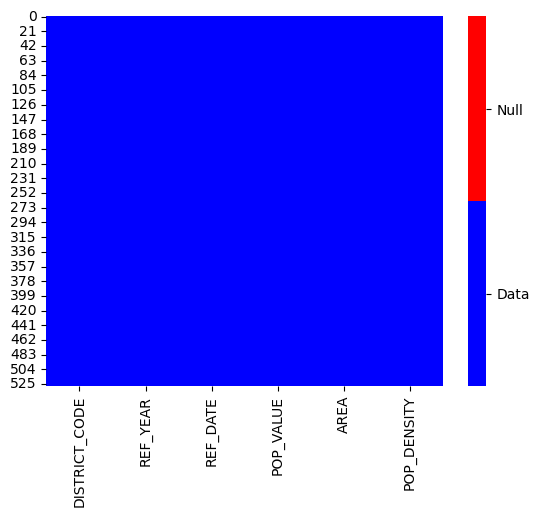

In [244]:
#Heatmap to show all data is there
colours = ['blue','red'] 
ax = sns.heatmap(data=bev_dichte.isnull(),cmap=sns.color_palette(colours), vmin=0, vmax=1)
colorbar = ax.collections[0].colorbar

colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels(['Data', 'Null'])

In [245]:
#Check if all districts are represented
print(bev_dichte['DISTRICT_CODE'].unique())
#Check if all years have 24 rows (so 1 value for each district + 1 row for whole of Vienna)
bev_dichte.groupby(by=['REF_YEAR']).size()

[90000 90100 90200 90300 90400 90500 90600 90700 90800 90900 91000 91100
 91200 91300 91400 91500 91600 91700 91800 91900 92000 92100 92200 92300]


REF_YEAR
2002    24
2003    24
2004    24
2005    24
2006    24
2007    24
2008    24
2009    24
2010    24
2011    24
2012    24
2013    24
2014    24
2015    24
2016    24
2017    24
2018    24
2019    24
2020    24
2021    24
2022    24
2023    24
dtype: int64

In [246]:
#Check for duplicates (no duplicate rows with same year and same district code)
bev_dichte.duplicated(subset=['DISTRICT_CODE', 'REF_YEAR']).any()

False

#### Analyse the Data

Now that we have the population density data for each district we can merge it with the dog data and compare it

In [247]:
#Merge population values and dog data, so we can analyse it
df_h4_dogs_pop = dogs_2002.merge(bev_dichte, how='inner', left_on=['DISTRICT_CODE','REF_YEAR'], right_on=['DISTRICT_CODE','REF_YEAR'], suffixes=('_dogs', '_population'))
df_h4_dogs_pop.head(10)

,NUTS,DISTRICT_CODE,REF_YEAR,REF_DATE_dogs,DOG_VALUE,DOG_DENSITY,Postal_CODE,REF_DATE_population,POP_VALUE,AREA,POP_DENSITY
0,AT13,90000,2002,2002-01-01,46933,29.87,1000,2002-01-01,1571123,414.87,3787.02
1,AT13,90100,2002,2002-01-01,542,30.74,1010,2002-01-01,17630,2.87,6145.48
2,AT13,90200,2002,2002-01-01,2251,25.29,1020,2002-01-01,89016,19.24,4626.13
3,AT13,90300,2002,2002-01-01,1904,23.16,1030,2002-01-01,82227,7.40,11115.15
4,AT13,90400,2002,2002-01-01,615,21.23,1040,2002-01-01,28975,1.78,16322.03
5,AT13,90500,2002,2002-01-01,862,17.31,1050,2002-01-01,49785,2.01,24748.48
6,AT13,90600,2002,2002-01-01,604,21.17,1060,2002-01-01,28525,1.46,19604.22
7,AT13,90700,2002,2002-01-01,532,18.40,1070,2002-01-01,28912,1.61,17977.33
8,AT13,90800,2002,2002-01-01,474,21.33,1080,2002-01-01,22219,1.09,20385.42
9,AT13,90900,2002,2002-01-01,865,22.59,1090,2002-01-01,38290,2.97,12903.62


In [248]:
#Check if all districts are still there
print(df_h4_dogs_pop['DISTRICT_CODE'].unique())
#Check if all years have 24 rows (so 1 value for each district + 1 row for whole of Vienna)
print(df_h4_dogs_pop.groupby(by=['REF_YEAR']).size())

[90000 90100 90200 90300 90400 90500 90600 90700 90800 90900 91000 91100
 91200 91300 91400 91500 91600 91700 91800 91900 92000 92100 92200 92300]
REF_YEAR
2002    24
2003    24
2004    24
2005    24
2006    24
2007    24
2008    24
2009    24
2010    24
2011    24
2012    24
2013    24
2014    24
2015    24
2016    24
2017    24
2018    24
2019    24
2020    24
2021    24
2022    24
2023    24
dtype: int64


In [249]:
#Check for missing values in merged dataframe
print(((df_h4_dogs_pop.isnull().sum() / len(df_h4_dogs_pop)) * 100).sort_values(ascending=False))

NUTS                   0.0
DISTRICT_CODE          0.0
REF_YEAR               0.0
REF_DATE_dogs          0.0
DOG_VALUE              0.0
DOG_DENSITY            0.0
Postal_CODE            0.0
REF_DATE_population    0.0
POP_VALUE              0.0
AREA                   0.0
POP_DENSITY            0.0
dtype: float64


Now that the data is merged we can analyse it

In [250]:
#Firstly, lets look at the number of dogs in districts over the years
fig = px.line(dogs_2002[dogs_2002['DISTRICT_CODE']!=90000], x='REF_YEAR', y='DOG_VALUE',
              color='Postal_CODE', markers=True,
              width=800, height=500,
                 labels={
                     "DOG_VALUE": "Number of Dogs",
                     "REF_YEAR": "Year",
                     "Postal_CODE": "Postal Code"
                  },
              title='Number of Dogs in each District from 2002 to 2023')
fig.show()

In [251]:
#Plot the population density for each district
#Need to exclude rows that show data for whole of Vienna
df_h4_dogs_pop_dist = df_h4_dogs_pop[df_h4_dogs_pop['DISTRICT_CODE']!=90000]

fig = px.scatter(df_h4_dogs_pop_dist, x='Postal_CODE', y='POP_DENSITY',
              color='Postal_CODE',
              hover_data='REF_YEAR',
              width=800, height=650,
                 labels={
                     "POP_DENSITY": "Density of Population (Population per km^2)",
                     "Postal_CODE": "Postal Code",
                     "REF_YEAR": "Year"
                  },
              title='Population Density in each District from 2002 to 2023')
fig.show()

To find out if there is a correlation between the number of dogs and the population density we can plot the number of dogs in each district and the population density for those districts against each other

In [252]:
#Show the number of dogs vs the population density for the most recent year (2023)
#Only data from 2023
df_h4_dogs_pop_2023 = df_h4_dogs_pop_dist[df_h4_dogs_pop_dist['REF_YEAR']==2023]

#Only show data for most recent year to make it clearer
fig = px.scatter(df_h4_dogs_pop_dist[df_h4_dogs_pop_dist['REF_YEAR']==2023], 
                y='DOG_VALUE', x='POP_DENSITY',
                hover_data='Postal_CODE',
                 color='Postal_CODE',
                 #text='Postal_CODE',
                 width=800, height=700,
                 labels={
                     "DOG_VALUE": "Number of Dogs",
                     "POP_DENSITY": "Density of Population",
                     "Postal_CODE": "Postal Code"
                 },
              title='Density of Population vs Number of Dogs in Vienna by District in 2023')
fig.update_traces(marker=dict(size=10))
#fig.update_traces(textposition=label_pos)
fig.show()

You can already tell that there is a negative correlation between the number of dogs and the population density in this plot, but let's plot a trendline over the data to make it more visible.

In [253]:
#Add trendline
coeffs = np.polyfit(df_h4_dogs_pop_2023['POP_DENSITY'], df_h4_dogs_pop_2023['DOG_VALUE'], 1)
vals = np.polyval(coeffs, df_h4_dogs_pop_2023['POP_DENSITY'])
    
line = px.line(x=df_h4_dogs_pop_2023['POP_DENSITY'], y=vals)

fig.add_trace(line.data[0])

The trendline shows there is a negative correlation.
Let's also calculate the pearson correlation coefficient:

In [254]:
df_h4_dogs_pop_dist['POP_DENSITY'].corr(df_h4_dogs_pop_dist['DOG_VALUE'], method='pearson')

-0.6109261359731252

The Pearson correlation coefficient indicates a negative correlation between the data, if the value is negative. Between 0 and –0.3 there is a weak negative correlation, between –0.3 and –0.5 there is a moderate negative correlation and if the value is less than –0.5 there is a strong negative correlation. 

The Pearson correlation coefficient we calculated is -0.61, which means that there is a moderate to strong correlation between the population density and the number of dogs.

### E3-H5: "The number of dogs in a Viennese district correlates positively with the number of dog waste bag dispensers that district."

Rationale: With the increasing number of dogs in Vienna, it needs to be assured that dog waste does not become an environmental or a public health issue. For this reason, it is desirable to have more dog poo bag dispensers in districts with a higher dog population. Therefore, the distribution of dog poo bag dispensers in each district is a crucial part in achieving an effective dog waste disposal. However, it remains unclear if this correlation between the dog population and number of dispensers exists or how it looks like. Understanding this relationship can help identify districts which are either underserved or overserved in terms of dog waste bag dispensers. Such insight can be taken into account for future city planning.

Datasets needed: vie-bez-biz-spo-dog-2002f.csv, HUNDESACKERLOGD.json, BEZIRKSGRENZEOGD.json

Further considerations: The data for the dog waste bag dispenser is up-to-date (file downloaded on 2024-10-10) for the dog data only the most recent data is considered, which is 2023. It is assumed that there is a negligible fluctuation in number and location of dispensers since 2023. Additionally, dogs and their owners are not restricted to their home district for their walks and the need for a dog poo bag dispenser.

Author: Anna Till


#### Obtain and scrub additional dataset
Dataset: Hundekotsackerlspender Standorte Wien (Dog poo bag dispensers)
File name: HUNDESACKERLOGD.json 
Source: https://www.data.gv.at/katalog/dataset/98908792-f315-4834-9b5e-20fed66cbe5a
Description: Location of each dog poo bag dispenser in Vienna up-to-date.

BEZ: Bezirk
STRNAM: Straßenname
ONRTEXT: Ordnungsnummer oder zusätzliche Lagebeschreibung
BEMERKUNG: weitere Informationen
ID_NR: Identifikationsnummer des Standortes

In [ ]:
import geopandas as gpd

dog_poo_bag_dispensers= gpd.read_file('HUNDESACKERLOGD.json') # load dog waste bag dispenser data

# Preview and info
print(dog_poo_bag_dispensers.info())
print(dog_poo_bag_dispensers.head())

# Missing values
print("Missing values: ",dog_poo_bag_dispensers.isnull().sum())
# missing data is irrelevant except for the district ('Bezirk') which is needed for each dispenser, which is zero

# Delete duplicates
dog_poo_bag_dispensers = dog_poo_bag_dispensers.drop_duplicates()

# Check geography (and delete if invalid)
print("Valid geography: ", dog_poo_bag_dispensers.geometry.is_valid.all())
dog_poo_bag_dispensers = dog_poo_bag_dispensers[dog_poo_bag_dispensers.geometry.is_valid]

# Check coordinate system
print("Coordindate system: ", dog_poo_bag_dispensers.crs)

#### Results:

In [ ]:
from scipy.stats import pearsonr

# Data for dog poo bag dispenser
dispensers_by_district = dog_poo_bag_dispensers.groupby('BEZIRK').size().reset_index(name='NUMBER_DISPENSER')  # count number of dispenser per district

# Dog data
dogs = dogs_2002.copy()
dogs['DISTRICT_CODE'] = dogs['DISTRICT_CODE'].astype(str)

# Filter for the latest year
latest_year = dogs['REF_YEAR'].max()
dogs_year = dogs[dogs['REF_YEAR'] == latest_year]

dogs_year = dogs_year.assign(BEZIRK=dogs_year['DISTRICT_CODE'].str[1:3].astype(int)) # district code has form 9BBZZ, we want only BB in order to merge

# Aggregate for each district
dogs_year = dogs_year.groupby('BEZIRK', as_index=False)[['DOG_VALUE', 'DOG_DENSITY']].sum()

# Merge data for dogs with data for dispensers
merged_data = pd.merge(dogs_year, dispensers_by_district, left_on='BEZIRK', right_on='BEZIRK', how='left')
merged_data['NUMBER_DISPENSER'] = merged_data['NUMBER_DISPENSER'].fillna(0)

# Calculation correlation and rations
correlation, _ = pearsonr(merged_data['DOG_DENSITY'], merged_data['NUMBER_DISPENSER'])
print(f'Pearson correlation: {correlation:.2f}')
# Ratios
merged_data['DOGS_TO_DISPENSER'] = merged_data['DOG_VALUE'] / merged_data['NUMBER_DISPENSER']
merged_data['DOGS_DENS_TO_DISPENSER'] = (merged_data['DOG_DENSITY'] / merged_data['NUMBER_DISPENSER'])*100

# District borders for graphical presentation
district_borders = gpd.read_file('BEZIRKSGRENZEOGD.json')
district_borders = district_borders.to_crs(epsg=4326)  # transform coordinates

# Merge district borders with dog and dispenser data
merged_data = district_borders.merge(merged_data, left_on='BEZNR', right_on='BEZIRK', how='left')

# Scatter plot for correlation
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['DOG_DENSITY'], merged_data['NUMBER_DISPENSER'], color='blue')
sns.regplot(x='DOG_DENSITY', y='NUMBER_DISPENSER', data=merged_data, scatter=False, ax=plt.gca(), color='red') # adds fit to plot
plt.xlabel('Dog Density (Dogs per 1000 People)')
plt.ylabel('Number of Dog Poo Bag Dispensers')
plt.title(f'Correlation between Dog Density and Number of Dog Poo Bag Dispensers ({latest_year})')
plt.grid()
plt.show()

# Maps with analysis of correlation in each district
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
merged_data.boundary.plot(ax=ax1, color='black')  # plot district borders
merged_data.boundary.plot(ax=ax2, color='black')    
fig.suptitle(f'Analysis of Dogs and Poo Bag Dispensers in Viennese Districts for {latest_year}', fontsize=16)

# First map: absloute number of dogs
merged_data.plot(column='DOGS_TO_DISPENSER', ax=ax1, legend=True, cmap='viridis', edgecolor='black', alpha=0.5, legend_kwds={'orientation': "horizontal", 'label': "number of dogs / number of dispensers", 'shrink': 0.8})
ax1.set_title('Ratio: Number of dogs to number of poo bag dispensers')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_ylabel('Latitude [degrees]')

for idx, row in merged_data.iterrows():  # ratio in each district in plot
    point = row.geometry.representative_point() 
    ax1.text(point.x, point.y, f'{int(round(row["DOGS_TO_DISPENSER"]))}', fontsize=10, ha='center', va='center', color='black')

# Second map: dog density per 1000 pop
merged_data.plot(column='DOGS_DENS_TO_DISPENSER', ax=ax2, legend=True, cmap='viridis', edgecolor='black', alpha=0.5,
                 legend_kwds={'orientation': "horizontal", 'label': "dog density / number of dispensers", 'shrink': 0.8})
ax2.set_title('Ratio: Dog density to number of poo bag dispensers')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_ylabel('Latitude [degrees]')
for idx, row in merged_data.iterrows():
    point = row.geometry.representative_point() 
    ax2.text(point.x, point.y, f'{row["DOGS_DENS_TO_DISPENSER"]:.2f}', fontsize=10, ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

# categorization
# low, medium, high
def categorize(value):
    if value <= merged_data['DOGS_DENS_TO_DISPENSER'].quantile(1/3):
        return 'Low'
    elif value <= merged_data['DOGS_DENS_TO_DISPENSER'].quantile(2/3):
        return 'Medium'
    else:
        return 'High'

merged_data['CATEGORY_DOG_TO_BAG'] = merged_data['DOGS_DENS_TO_DISPENSER'].apply(categorize)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_data.boundary.plot(ax=ax, color='black')
merged_data.plot(column='CATEGORY_DOG_TO_BAG', ax=ax, legend=True, cmap='Set1', edgecolor='black', alpha=0.5)
ax.set_title(f'Categorization: Dog Density per 1000 people to Dog Poo Bag Dispenser ({latest_year})')
ax.set_xlabel('Longitude [degrees]')
ax.set_ylabel('Latitude [degrees]')
for idx, row in merged_data.iterrows():
    point = row.geometry.representative_point()
    ax.text(point.x, point.y, row['BEZ_RZ'], fontsize=10, ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

#### Answer:
The Pearson correlation coefficient of 0.70 indicates a positive correlation between the number of dogs and of dispensers in a district. Which means, that indeed in districts with a higher dog population also a higher number of dog poo bag dispensers is installed. However, in the scatter plot ("Correlation between Dog Density and Number of Dog Poo Bag Dispensers (2023)") it can be seen that there are some outliers despite the correlation depicted by the trend line.

Another aspect is the comparison ("Analysis of Dogs and Poo Bag Dispensers in Viennese Districts for 2023") between the ratios of the number of dogs per dog waste bag dispenser in each district and of the density of dogs per dispenser, which takes also population density into account. The direct comparison between the absolute numbers - dogs per dispenser - suggests that a higher ratio may need a more frequent refill, assuming one waste bag per dog poo. As displayed in the results ("Ratio: Number of dogs to number of poo bag dispensers") this is the case especially in the outer districts of Vienna. Whereas, the broader context of the dog density per dog waste bag dispenser, normalizing the number of dogs against the population, implies whether there are enough dispensers available for each resident (regardless if or how many dogs they own). In this case, the results ("Ratio: Dog density to number of poo bag dispensers") show a different picture than for the direct ratio. Here, the inner districts of Vienna are affected the most by having the higher dog density to dispenser ratio. For instance, the first district, "Innere Stadt", has a rather low number of dogs per dispenser. However, value of the dog density to dispensers is exceedingly high compared to other districts. 

Finally, the map "Categorization: Dog Density per 1000 people to Dog Poo Bag Dispenser (2023)" provides a further investigation of dog density per dispenser by categorizing the districts into "high", "medium" and "low" based on tertiles. It can be seen at glance that the innermost districts might profit most from additional dog waste bag dispensers with respect to each resident.

In summary, there is a correlation between the dog population and the number of dog waste bag dispensers. The number of dogs per dispenser is larger in the outer districts of Vienna, whereas when also taking the population per district into account, the picture reverses.

### E3-H6: "xxx"
Author: Group member 6
